# 多層パーセプトロン (MLP: Multi-Layer Perceptron)

![](https://cdn-ak.f.st-hatena.com/images/fotolife/n/nkdkccmbr/20161006/20161006215155.png)  
MLPのイメージ 出典：[３層パーセプトロン -- ニューラルネットワーク・DeepLearningなどの画像素材　プレゼン・ゼミなどに【WTFPL】](https://nkdkccmbr.hateblo.jp/entry/2016/10/06/222245)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import display, Markdown


## はじめに

[パーセプトロン（Perceptron）](https://rsimd.github.io/textbook/perceptron.html)では，単純パーセプトロンでは線形分離できない問題を解くことができなかったのに，複数のパーセプトロンを組み合わせて階層構造にすることで解ける問題があることがわかりました．

![](./figs/perceptron/mlp.png)
図：多層パーセプトロン

XOR問題のように，問題を人の手で細分化して個別の問題を線形分離可能な問題にすることができるならば，パーセプトロンの学習則を使った訓練で様々な問題を解くためのMLPを組むことができそうです．
これに対して，現実世界の問題は線形分離可能な問題に細分化することが難しい場合が殆どです．非線形問題に対応するために，私たちにはMLPの訓練のための新しいアルゴリズムが必要になります．

## MLPによる問題の解き方

ニューラルネットワークは，入力されるデータ行列に対して，学習可能なパラメータを使った線形変換と非線形な活性化関数（activation function）を交互に適用することで様々なタスクを解くことができると知られている機械学習モデルです．

:::{note}
この曖昧な説明の気持ちは，__普遍性定理(universal approximation theorem)__ {cite:ps}`Hornik1989-cu`をベースにしています．

> Universal Approximation Theorem (日本語では"普遍性定理"と呼ばれる)は、有限個のユニットを持つ一層の隠れ層で構成されるfeed-forward networkは、いくつかの条件のもと、任意の連続関数を近似することが出来る、という定理。
>
> 言い換えると、feed-forward networksを使うことで適当な連続関数を近似できることが理論的に保証された、ということ。
>
> [ニューラルネットワークにおけるUniversal Approximation Theorem(普遍性定理)について](https://qiita.com/cfiken/items/e2047d9b27e6ef2a132b)

これに関する論文は何本もあるので，代表的なものをいくつか示しておきます．

- {cite:ps}`Cybenko1989-dm`
    - 任意幅のニューロンでsigmoid関数の場合
- {cite:ps}`Hornik1989-cu`
    - 隠れ層が1層しかない多層フィードフォワードネットワークは普遍的な近似器らしい
- {cite:ps}`Hornik1991-gh`
    - 活性化関数はなんでも良いらしい
- {cite:ps}`Leshno1993-sj`
- {cite:ps}`Pinkus1999-hg`

:::

私たちはこれから，何らかのタスクをうまく解くことができるように，MLPのパラメータを設定する方法を考えていかなければなりません．そのためにまず，MLPにデータ行列を入力してから，最終的にMLPから出力値が出てくるまでの様子を追ってみましょう．これを順伝播（Forward Propagation）と呼びます．

### MLPの順伝播の全体像

MLPの順伝播の様子を考えていきましょう．
入力されるデータはmini batch単位で考えたいので，ミニバッチサイズ$m$，特徴数$f$とするとミニバッチは$\mathbf{X} \in \mathbb{R}^{m \times f}$です．



図のようなMLPでは，
- 入力層→隠れ層の間にweightとbias
- 隠れ層→出力層の間にweightとbias

の四つのパラメータがあるので，隠れ層のユニット数を$k$としてそれぞれを
$\mathbf{W}^{(0)}\in \mathbb{R}^{f \times k}, \mathbf{b}^{(0)}\in \mathbb{R}^{k}, \mathbf{W}^{(1)}\in \mathbb{R}^{k \times c}, \mathbf{b}^{(1)}\in \mathbb{R}^{c}$とおきましょう．


すると，活性化関数を$f$とすると隠れ層は：

$$
\mathbf{H} = f(\mathbf{X} \cdot \mathbf{W}^{(0)} + \mathbf{b}^{(0)})
$$

で計算できます．また，パーセプトロンでは活性化関数として符号関数を利用していましたが，ここからは（パラメータの学習のために）微分可能な（滑らかな）活性化関数を使っていきます．今回はとりあえず$f$を標準シグモイド関数だとして考えていきます．

$$
\operatorname{sigmoid}(x) = \frac{1}{1+\operatorname{exp}(-x)}
$$

行列演算だけでなぜニューラルネットワークの全結合層を再現できているのかが分からない人は，[解説ページ](./matrix_ops.ipynb) を見てください．


また，活性化関数を$g$とすると出力層は：

$$
\mathbf{\hat{Y}} = g(\mathbf{H} \cdot \mathbf{W}^{(1)} + \mathbf{b}^{(1)})
$$

となります．


$g$はクラス分類問題ならばSoftmax関数を使うことが多いです．softmaxはカテゴリカル分布のパラメータのような配列を返す関数です．

$$
\operatorname{softmax}(\mathbf{x})_i = \frac{\operatorname{exp}({x}_i)}{\sum_{k=1}^{f}\operatorname{exp}({x}_k)}
$$


また．回帰問題ならば恒等関数（活性化関数無し）になります．

$$
\operatorname{identity}(x) = x
$$


### 損失関数

私たちは何かしらのアルゴリズムを使って，MLPが目的の課題の答えを出力できるように学習可能パラメータを修正したいと考えていました．いきなり正しい答えが得られるような素晴らしいパラメータが得られるならば最高なのですが，おそらく難しいでしょう．これは典型的な組み合わせ問題になってしまうので，パラメータの数が多ければ多いだけ正しい数値の組み合わせを見つけるのは難しそうなのは想像に難くありません．

さて，では徐々にパラメータを更新して理想の答えが出せるモデルに近づけていくことにします．そのためには，現状のパラメータを使ったモデルが **どのくらい正しい期待通りに機能するのかを定量的に評価することができ，パラメータ更新の指針になる関数** が必要があります．これを __損失関数__ と呼びます．

損失関数には様々な関数が利用されますが，回帰問題ならば二乗和誤差が用いられることが多いようです．クラス分類問題ならば，クロスエントロピーが利用されることが多いようです．


#### 二乗和誤差

$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - t_i)^2
$$

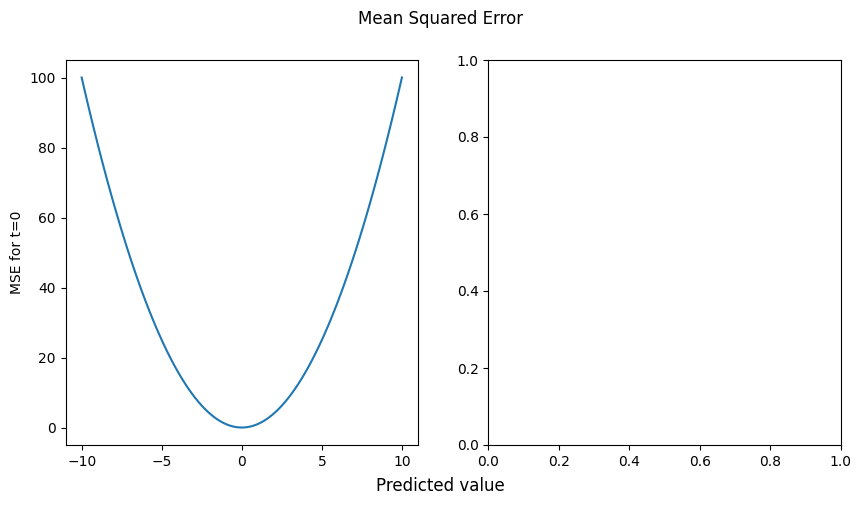

In [29]:
mean_square_error =lambda y,t:((y-t)**2).mean(axis=-1)


y = np.linspace(-10,10,100)
y = y.reshape([y.size,-1])
t = np.zeros(100)
t = t.reshape([t.size,-1])

fig = plt.figure(figsize=[10,5])
fig.suptitle("Mean Squared Error")
fig.supxlabel("Predicted value")
ax = fig.add_subplot(1,2,1)
ax.plot(y, mean_square_error(y,t))
ax.set_ylabel("MSE for t=0")
ax2 = fig.add_subplot(1,2,2)

## MLPの順伝播



例えばこれがクラス分類問題を解くためのMLPだとすれば，$g$が$\operatorname{softmax}$でほぼ確定します．$f$は活性化関数として知られている関数ならおそらくどれでも大丈夫です．

## 参考文献

### 論文等

```{bibliography}
:filter: docname in docnames
```

### Web
1. test
2. test2